<a href="https://colab.research.google.com/github/dundurlunka/ml-grand-slam/blob/main/ml_grand_slam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Read data from github

In [30]:
import pandas as pd
import numpy as np

import sys
import csv

In [31]:
csv.field_size_limit(sys.maxsize)

points = pd.read_csv('./charting-m-points-from-2017.csv', quoting=csv.QUOTE_NONE, encoding = 'ISO-8859-1')
matches = pd.read_csv('./charting-m-matches.csv', quoting=csv.QUOTE_NONE, encoding = 'ISO-8859-1')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (8,9,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Merge the two datasets together by match_id

In [32]:
joinedData = pd.merge(
    matches,
    points,
    how="inner",
    on='match_id',
)

In [33]:
df_obj = joinedData.select_dtypes(['object'])
joinedData[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

Select relevant columns from dataframe


In [34]:
joinedData.columns = joinedData.columns.to_series().apply(lambda x: x.strip())
joinedData = joinedData.loc[:, ['Player 1', 'Player 2', 'Pl 1 hand', 'Pl 2 hand', 'Tournament', 'Surface', 'Set1','Set2', 'Gm1', 'Gm2', 'Pts', 'Serving', '1st', '2nd', 'isAce', 'isUnret']]

In [35]:
joinedData['isAce'] = joinedData['isAce'] | joinedData['isUnret']
joinedData = joinedData.drop(columns=['isUnret', 'isAce'])

In [36]:
tennis_players = ['Daniil Medvedev', 'Alexander Zverev', 'Roger Federer', 'Dominic Thiem', 'Nick Kyrgios', 'Novak Djokovic', 'Rafael Nadal', 'Stefanos Tsitsipas', 'Casper Ruud', 'Grigor Dimitrov']
tennis_players_initials = [''.join([x[0].upper() for x in fullname.split(' ')]) for fullname in tennis_players]
joinedData = joinedData.loc[((joinedData['Player 1'].isin(tennis_players)) | (joinedData['Player 2'].isin(tennis_players)))]
joinedData = joinedData.loc[joinedData['Serving'].isin(tennis_players_initials)]

In [37]:
joinedData[['Pts1', 'Pts2']] = joinedData['Pts'].str.split('-', expand=True)
joinedData = joinedData.drop('Pts', axis='columns')

Separate the columns into new columns that are specific for Server and Returner.

In [38]:
names = []
pointsServer = []
pointsReturner = []
gamesServer = []
gamesReturner = []
setsServer = []
setsReturner = []
handReturner = []
for index, row in joinedData.iterrows():
    if ''.join([x[0].upper() for x in row['Player 1'].split(' ')]) == row['Serving']:
      names.append(row['Player 1'])
      pointsServer.append(row['Pts1'])
      pointsReturner.append(row['Pts2'])
      gamesServer.append(row['Gm1'])
      gamesReturner.append(row['Gm2'])
      setsServer.append(row['Set1'])
      setsReturner.append(row['Set2'])
      handReturner.append(row['Pl 2 hand'])
    elif ''.join([x[0].upper() for x in row['Player 2'].split(' ')]) == row['Serving']:
      names.append(row['Player 2'])
      pointsServer.append(row['Pts2'])
      pointsReturner.append(row['Pts1'])
      gamesServer.append(row['Gm2'])
      gamesReturner.append(row['Gm1'])
      setsServer.append(row['Set2'])
      setsReturner.append(row['Set1'])
      handReturner.append(row['Pl 1 hand'])

joinedData['FullNameServer'] = names
joinedData['PointsServer'] = pointsServer
joinedData['PointsReturner'] = pointsReturner
joinedData['GamesServer'] = gamesServer
joinedData['GamesReturner'] = gamesReturner
joinedData['SetsServer'] = setsServer
joinedData['SetsReturner'] = setsReturner
joinedData['HandReturner'] = handReturner

joinedData = joinedData.drop(columns=['Player 1', 'Player 2', 'Pts1', 'Pts2', 'Gm1', 'Gm2', 'Set1', 'Set2', 'Pl 1 hand', 'Pl 2 hand', 'Serving'])

Combine the serves into one column with a list of 1 or 2 serves so that it can be exploded into several rows later

In [39]:
joinedData['Serves'] = joinedData.apply(lambda x: list(['f' + str(x['1st']),
                                                        's' + str(x['2nd'])]), axis=1)   

Explode list of first and second serve into separate rows

In [40]:
joinedData = joinedData.explode('Serves')

Add new column indicating whether the serve was first or second

In [41]:
joinedData['IsFirstServe'] = joinedData['Serves'].str[0] == 'f'

Remove 'f' and 's' (first and second serve) that were indicators before the explosion

In [42]:
joinedData['Serves'] = joinedData['Serves'].str[1:]
joinedData = joinedData[(joinedData['Serves'] != 'nan') & (joinedData['Serves'] != '')]
joinedData = joinedData.drop(columns=['1st', '2nd'])

Remove lets

In [43]:
joinedData['Serves'] = joinedData['Serves'].map(lambda x: x.lstrip('c'))

In [44]:
joinedData['FullNameServer'].value_counts()

Roger Federer         12724
Novak Djokovic        12549
Daniil Medvedev       12427
Stefanos Tsitsipas    10837
Rafael Nadal          10717
Dominic Thiem         10051
Alexander Zverev       8100
Nick Kyrgios           7470
Casper Ruud            5300
Grigor Dimitrov        5101
Name: FullNameServer, dtype: int64

Extract direction of serve

In [45]:
def extract_serve_direction(row):
  serves_directions_dict = {
      '4': 'Out wide',
      '5': 'Body',
      '6': 'Down the T'
  }

  if len(row['Serves']) > 1 and row['Serves'][1] in ['x', 'd', 'w', 'n', 'g', '!', 'e']:
      return "Fault"
  else:
      return serves_directions_dict.get(row['Serves'][0], 'Body')

joinedData['Direction'] = joinedData.apply(extract_serve_direction, axis=1)
joinedData = joinedData.drop(columns='Serves')

# Start of machine learning

### Data exploration

In [46]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

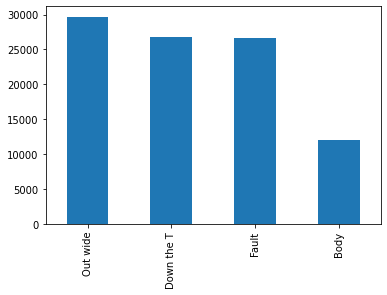

In [47]:
joinedData['Direction'].value_counts().plot(kind='bar')

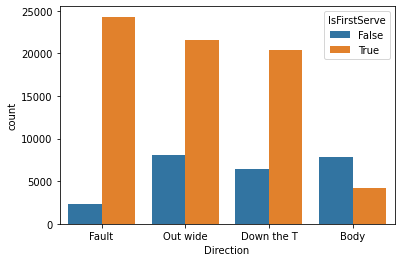

In [48]:
sns.countplot(
    x = 'Direction',
    hue = 'IsFirstServe',
    data = joinedData,
)

## Pre-processing

In [128]:
X = joinedData.drop(columns=['Direction'])
y = joinedData['Direction']
print(y)

637            Fault
637         Out wide
638            Fault
638       Down the T
639         Out wide
             ...    
295482      Out wide
295483         Fault
295483      Out wide
295484         Fault
295484          Body
Name: Direction, Length: 95276, dtype: object


### One hot encoding attributes

In [131]:
X.shape[1]

11

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

categorical_columns = ['Tournament', 'Surface', 'FullNameServer', 'PointsServer', 'PointsReturner', 'HandReturner']

from sklearn.preprocessing import LabelEncoder
transformer = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    remainder='passthrough')

transformed = transformer.fit_transform(X)
print(transformed)

# print(transformed)
# print(transformer.get_feature_names_out())
transformed_df = pd.DataFrame([transformed], columns=transformer.get_feature_names_out())
transformed_df.head()

### Label encoding the label

In [85]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

### Splitting into train test

In [91]:
X = X.iloc[:, :-1].values

[[<1x118 sparse matrix of type '<class 'numpy.float64'>'
  	with 6 stored elements in Compressed Sparse Row format> 0 0 0 0]
 [<1x118 sparse matrix of type '<class 'numpy.float64'>'
  	with 6 stored elements in Compressed Sparse Row format> 0 0 0 0]
 [<1x118 sparse matrix of type '<class 'numpy.float64'>'
  	with 6 stored elements in Compressed Sparse Row format> 0 0 0 0]
 ...
 [<1x118 sparse matrix of type '<class 'numpy.float64'>'
  	with 6 stored elements in Compressed Sparse Row format> 5 4 1 1]
 [<1x118 sparse matrix of type '<class 'numpy.float64'>'
  	with 6 stored elements in Compressed Sparse Row format> 5 4 1 1]
 [<1x118 sparse matrix of type '<class 'numpy.float64'>'
  	with 6 stored elements in Compressed Sparse Row format> 5 4 1 1]]


AttributeError: ignored

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## KNN

In [88]:
def plot_knn_scores(ks):
    train_scores = []
    test_scores = []
    
    for k in ks:
        clf = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 6))
    plt.plot(ks, train_scores, color='blue', label='train score')
    plt.plot(ks, test_scores, color='green', label='test score')
    plt.legend()

In [89]:
plot_knn_scores(range(1, 13, 2))

ValueError: ignored

In [ ]:
# pd.set_option('display.max_rows', 500)
# joinedData.head(500)

print(X_train)